<a href="https://colab.research.google.com/github/andtab/fbi-most-wanted/blob/main/FBI_Most_Wanted_NLP_Pipeline_ROUGH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**FBI Most Wanted Fugitives - Crime Categorization Model**


#**Imports**

The imports used to accomplish model development are initialized in this section.

In [ ]:
# BeautifulSoup is used to extract useful information from the requests
from bs4 import BeautifulSoup

# storing retrieved data in a dataframe
import pandas as pd

# "requests" library is used to send an http request to access information on 
# desired webpages
import requests

# To preserve order of dictionaries used to build dataframes
from collections import OrderedDict, Counter

# "time" library used to add optional sleep in between HTTP GET requests
import time

# Used for file naming of csv output
from datetime import date

In [ ]:
# Numpy library for data manipulations additional to what will be accomplished
# using pandas
import numpy as np

In [ ]:
# Natural Language Processing Toolkit (NLTK) library used to perform 
# tokenization on the text to be used as features for the model
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

from nltk import ngrams

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
# from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin



from sklearn.metrics import f1_score, make_scorer


from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

#**Feature Transformers**

Transformers applied to features are listed in this section

In [ ]:
# Transformer a pandas series of text such that words can be lowercased,
# special characters can be removed, specified stopwords can be removed, and the 
# text can be stemmed or lemmatized 
class TokenizerTransformer(BaseEstimator):
  def __init__(self, lowercase = True, 
               special_character_removal = True, 
               number_removal = True,
               stopword_removal = True, 
               stopwords_list = stopwords.words('english'), 
               stemmer = SnowballStemmer('english'), 
               lemmatizer = WordNetLemmatizer(),
               join_words = True):
    
    special_characters_list = '\.,;?!:@#()'
    number_list = '0-9'
    # Store transformation settings as properties of the class' instance
    self.lowercase = lowercase
    self.special_character_removal = special_character_removal
    self.number_removal = number_removal
    self.stopword_removal = stopword_removal
    self.stopwords_list = stopwords_list
    self.stemmer = stemmer
    self.lemmatizer = lemmatizer
    self.join_words = join_words
    self.special_characters_list = special_characters_list 

  # Describe the "fit" method of this class here 
  def fit(self, input_column, y = None, **fit_params):

    return self

  # Describe the "transform" method of this class here 
  def transform(self, input_column, y = None):

    # Apply lowercasing to text if the "lowercase" property is set to "True"
    if self.lowercase:
      input_column = input_column.str.lower()

    # Apply special character removal to text if the property is set to "True"
    if self.special_character_removal:

      input_column = (input_column.str.replace("\s|[\.,;?!:@#'“”’\"]", ' ', regex = True).str.split()).map(' '.join)
 
    # Apply number removal to text if the property is set to "True"   
    if self.number_removal:
      input_column = (input_column.str.replace("\s|[\0-9']", ' ', regex = True).str.split()).map(' '.join)

    # Separate each string of the column into lists of words
    input_column = input_column.str.split()

    # Apply stopword removal if specified as a requirement
    if self.stopword_removal:
      input_column = input_column. \
      apply(lambda r: \
            [word for word in r if not word in self.stopwords_list])
      
    # Apply stemming if no lemmatization is specified
    if self.stemmer != None and self.lemmatizer == None:
      input_column = input_column. \
      apply(lambda r: \
            [self.stemmer.stem(word) for word in r])  

    # Apply lemmatization if no stemming is specified
    elif self.stemmer == None and self.lemmatizer != None:
      input_column = input_column. \
      apply(lambda r: \
            [self.lemmatizer.lemmatize(word) for word in r]) 

    # Apply both stemming and lemmatization if specified      
    elif self.stemmer != None and self.lemmatizer != None:
      input_column = input_column. \
      apply(lambda r: \
            [self.stemmer.stem(self.lemmatizer.lemmatize(word)) for word in r])      

    # Join tokenized text prior to returning output if specified
    if self.join_words:
      input_column = input_column.str.join(' ')

    # Return the resulting column
    return input_column

In [ ]:
# Boolean encoder created as an alternative to text transformers such as
# CountVectorizer and TfidfVectorizer from sci-kit learn
class BooleanEncoder(TransformerMixin, BaseEstimator):
  def __init__(self, vocabulary = None):

    # Store vocabulary as property of class object instance
    self.vocabulary = vocabulary


  def fit(self, X, y = None, **fit_params):
    return self

  def transform(self, X, y = None, **fit_params):

    # Initialize list which will be used to create array of encoded results
    final_list = []
    X_result = X.str.split()

    # In the case of vocabulary not being set when the class is instantiated,
    # create the vocabulary from the unique words found within the input
    # feature set
    if self.vocabulary is None:
      self.vocabulary = list(frozenset(X.str.split().explode()))

    # Set either 1 or 0 for every word in the vocabulary for each example, 
    # according to whether or not the vocabulary words are present in examples
    for r in X_result:

      final_list.append([1 if x in r else 0 for x in self.vocabulary])

    # Return a numpy array of the final results
    return np.array(final_list)

In [80]:
# Transform sparse matrix into an array - conversion to sparse matrix format
# occurs in the use of text vectorizer classes such as sklearn's CountVectorizer
class DenseTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):

        # If the prior transformer has an output that is not a numpy array, (in
        # this case, a sparse array resulting from use of sklearn vectorizers),
        # convert to numpy array prior to producing this transformer's output
        try:
          output = X.toarray()

        # If the prior transformer already output a numpy array, do not apply
        # any further transformation to the data and return the input as the 
        # output of this transformer
        except:
          output = X
          
        return output

In [ ]:
# Append additional features to those derived from text encoding methods such
# as TF-IDF
class ArrayAppender(BaseEstimator, TransformerMixin):

  # Upon initialization, store the input dataframe to be appended as a parameter
  # of an instance of the class 
  def __init__(self, df_append):
    self.df_append = df_append

  # Fit method
  def fit(self, X, y = None, **fit_params):
    return self

  # Tranform method which includes the procedure on building a column to be 
  # appended to the dataset being fit through a machine learning pipeline
  def transform(self, X, y = None, **fit_params):

    # If the input dataframe only has a single column, when converting the 
    # dataframe into an array, specify the number of columns as 1
    if len(self.df_append.shape) == 1:
      X_append = self.df_append[X.index].to_numpy().reshape(-1, 1)

    # Otherwise, reshape the resulting array such that the column count matches
    # that of the input dataframe. Note that with a one column dataframe, we
    # do not have access to the "columns" method, hence the need for this if
    # statement
    else: 
      X_append = self.df_append.iloc[X.index,:].to_numpy().reshape(-1, len(self.df_append.columns))

    # Return the resulting array
    return X_append

#**Helper Functions**

Helper functions made out of convenience are written out in this section.

In [ ]:
# Function to generate a dataframe of the class counts in each class of 
# a given dataset; inputs are (1) the column of labels from the dataset to be 
# analyzed, (2) the title of the column in the function's output containing 
# class counts, (3) the title of the column in the function's output containing
# fraction of total classes for each class, and lastly the index title for the
# output dataframe
def class_counts(class_label_series, count_title, fractional_count_title, index_title):

  # Use a counter object to determine counts for each class, convert to an 
  # ordered dictionary so that the data can be used to build a dataframe
  
  # Title columns based on specification in function input
  classes_df = pd.DataFrame.from_dict(OrderedDict(Counter(class_label_series)), orient = 'index', columns = [count_title])

  # Title index based on specification in function input
  classes_df.index.name = index_title

  # Build column of fraction of total class count for each class, title 
  # according to function input specification
  classes_df[fractional_count_title] = classes_df[count_title] / classes_df[count_title].sum()
  return classes_df

In [ ]:
# Function used to determine the count of a specified label type for each 
# example in the dataset
def label_count(labelled_text, label_name):
  label_counts = labelled_text.apply(lambda r: len([label for label in list(zip(*r))[1] if label == label_name]))
  return label_counts

In [ ]:
def composition_analysis(input_dataset, labels, v = False, item_name = 'sentence'):

  # Capitalize provided name of items for which frequencies will be determined
  item_name = item_name.capitalize()

  # Initialize empty lists of items
  item = []
  item_counts = []
  labels_list = []

  # Extract unique class names
  class_names = pd.unique(labels)

  # Instantiate counter for total words used across all classes in the dataset
  results_total = Counter()

  # Loop through each class present in the data
  for class_label in class_names:

    # Instantiate counter for total words used on a per-class basis
    results = Counter()

    # Retrieve the indices corresponding to each class in the provided labels 
    # column    
    class_members_index = (labels == class_label).index[np.where(labels == class_label)]

    # Using the extracted indices, get the corresponding features for a given
    # class
    input_dataset_class = input_dataset[class_members_index]

    # Use the numpy vectorize function to update the word counts of a class 
    # without the reliance on a for loop
    if v:
      vectorized_counter = np.vectorize(results.update) 
      vectorized_counter(input_dataset_class)
    
    else: 
      results.update(input_dataset_class)

    print(class_label)
    print(results, '\n')

    # Build a list of words used in each class and concatenate in each iteration
    item += list(OrderedDict(results).keys())

    # Build a list of word counts for each word in a given class and concatenate
    # in each iteration
    item_counts += list(OrderedDict(results).values())

    # Build a list as long as the list of words for a given class
    labels_list += [class_label] * len(list(OrderedDict(results).values()))

  # Produce the counter for the words within the total dataset
  if v:
    vectorized_counter_total = np.vectorize(results_total.update)
    vectorized_counter_total(input_dataset)

  else:
    results_total.update(input_dataset)

  # Present the total word after within class word counts have been determined
  print('Total Count')
  print(results_total, '\n')

  # Create a dataframe from the words, word_counts, and labels lists that will
  # be used to construct a barplot 
  item_df = pd.DataFrame([item, item_counts, labels_list], [item_name + 's', item_name + ' Counts', 'Labels']).T

  # Return the dataframe
  return item_df 
  # https://community.plotly.com/t/remove-trace-0-next-to-hover/33731

In [ ]:
def distribution_plot(input_df, max_count = 20):

  # Sort input dataframe from largest to smallest word counts
  input_df = input_df.sort_values(by = input_df.columns[1], ascending = False)

  # Create a bar plot representing word counts for the top words selected
  # Note that the input dataframe (input_df) must have columns 'Word Counts',
  # 'Words', and 'Labels' for this line to work. A dataframe with these column
  # headers is generated using the word_composition_analysis function
  fig = px.bar(input_df.iloc[0:max_count, :], x = input_df.columns[1], y = input_df.columns[0], color = input_df.columns[2], orientation = 'h')
  
  # Update the legend to remove the "Labels="
  fig.for_each_trace(lambda t: t.update(name= t.name.split("=")[1]))

  # Update the figure to order the words as we desire
  fig.update_layout(yaxis={'categoryorder':'total ascending', 
                          'tickvals': list(range(0, max_count))})

  # display the plot
  fig.show()


In [ ]:
# Function to get plots of the frequencies for quantifiable dataset properties
#  of each class (e.g. sentence count distribution for each class)
def property_count_distribution_plot(input_df, labels, column_count, title):

  class_names = pd.unique(sent_df['Labels']) 

  max_plots_per_column = round(len(class_names)/ column_count)


  fig = make_subplots(rows = max_plots_per_column, cols= column_count)

  class_idx = 0

  for col_idx in range(1, column_count + 1):
    row_idx = 1
    while row_idx <= max_plots_per_column:
      if class_idx < len(class_names):
        class_name = class_names[class_idx]
        class_idx += 1

      else:
        break

      
      input_df_class = input_df[input_df['Labels'] == class_name].sort_values(by = input_df.columns[1], ascending = False)


      fig.add_trace(go.Bar(y = input_df_class.iloc[:, 0], x = input_df_class.iloc[:, 1], orientation = 'h', name = class_name),
            row = row_idx, col = col_idx)

      fig.update_xaxes(dtick = 2, row = row_idx, col = col_idx)
      fig.update_yaxes(tickvals = list(range(0, max(input_df_class.iloc[:, 0]) + 1, int(max(input_df_class.iloc[:, 0])/ 7))), row = row_idx, col = col_idx)

      row_idx += 1

      len(class_names)

  fig.update_traces(marker_line_color='black',
                  marker_line_width=1.5, opacity=1, width = 1)

  fig.update_xaxes(showgrid = False)


  fig.update_layout(title = title)

  fig.show()

In [ ]:
def class_counter(input_array, labels, class_name):
  counter = Counter(input_array[labels == class_name].str.split().explode())

  return counter

In [50]:
# Function to generate vocabulary based on ratio of most frequent words to 
# include from each class in the training dataset
# Input feature data, labels for each example, and list containing the fraction of unique words from 
# each class' total word count count
# Set 'unique' keyword as False if there is no restriction for the selected 
# terms to be unique to each class - otherwise set to True
# Set "stats" to true if an overview of feature selection upon running the 
# function is required
def vocabulary_generator(input_array, labels, class_fraction, unique = False, stats = False):


################################################################################
  def fractional_feature_selection(idx, class_fraction, word_count):     
    # Convert the fraction of unique words for a class into a count of unique
    # words
    if class_fraction[idx] * word_count == 0:
      features_selected = 0

    elif class_fraction[idx] * word_count < 1:
      features_selected = 1

    else:
      features_selected = round(class_fraction[idx] * word_count) 

    return features_selected
################################################################################

  # Initialize list to store word counts
  word_count_list = []
  features_selected_list = []

  # Extract unique class labels from the training dataset
  classes_array = np.unique(labels)

  # Initialize a counter which will keep track of all the words selected across
  # all classes and their total counts
  total_counter = Counter()

  # Convert the provided fraction of class words into a count of words to
  # include in building the training set 
  if unique == False:

    for idx, class_name in enumerate(classes_array):

      # Build a counter for the words corresponding to each class
      counter = class_counter(input_array, labels, class_name)

      # Set count of unique words 
      word_count = len(counter)

      # Convert the fraction of unique words for a class into a count of unique
      # words
      features_selected = fractional_feature_selection(idx = idx, class_fraction = class_fraction, word_count = word_count)

      # Update the total count of most frequent words in each class using the 
      # "update" method
      total_counter.update(Counter(OrderedDict(counter.most_common(n = features_selected))))  

      # Add to the selected feature list
      features_selected_list.append(features_selected)

      # Add to the list of word counts for each class
      word_count_list.append(word_count)

  else: 

    for idx, class_name in enumerate(classes_array):

      # Retrieve the indices representing the examples in the dataset
      # corresponding to a particular class
      class_members_index = input_array[labels == class_name].index
      
      # Use these indices to get the subset of the dataset pertaining to a 
      # particular class
      input_array_class = input_array[class_members_index]

      # Explode dataset elements such that an array of the words found within 
      # a certain class' examples is formed
      class_terms = input_array_class.str.split().explode().values

      # Extract the terms from the examples which NOT correspond to the 
      # class being analyzed - the goal is to determine which words are unique
      # to each class
      remaining_terms = input_array[~input_array.index.isin(class_members_index)].str.split().explode().values

      # Form an immutable set (frozenset) of the remaining terms, to get the 
      # unique words within the set
      remaining_terms_unique = frozenset(remaining_terms)

      # Apply the following list comprehension to return only the words which
      # are found in a particular class and not in the others
      class_terms_unique = [item for item in class_terms if item not in remaining_terms_unique]

      # Create a counter of these unique class terms
      counter = Counter(class_terms_unique)

      # Determine the number of different words
      word_count = len(counter)

      # Convert the fraction of unique words for a class into a count of unique
      # words
      features_selected = fractional_feature_selection(idx = idx, class_fraction = class_fraction, word_count = word_count)

      # Update the total count of most frequent words in each class using the 
      # "update" method
      total_counter.update(Counter(OrderedDict(counter.most_common(n = features_selected))))  

      # Add to the selected feature list
      features_selected_list.append(features_selected)

      # Add to the list of word counts for each class
      word_count_list.append(word_count)


  # After looping through each class, build a list of words to include in the 
  # vocabulary 
  vocabulary = list(OrderedDict(total_counter).keys())

  # If stats of the feature selection are required, the code within this 'if'
  # statement will be executed
  if stats:

    print('***Feature Selection Statistics***')

    # Print the fraction of words selected for each class out of the entire set
    # (whether that set is unique to each class or not)
    for idx, class_name in enumerate(classes_array):
      print(idx, ' - ', class_name, ': ', features_selected_list[idx], '/', word_count_list[idx], '=', round(features_selected_list[idx]/word_count_list[idx], 3))

    # Display the total number of features, total number of examples, along with
    # a ratio of features to examples
    print('Total Feature Count: ', sum(features_selected_list))
    print('Total Examples: ', len(labels))

    print('Feature Count - Examples Ratio: ', sum(features_selected_list), '/', len(labels), '=', round(sum(features_selected_list)/len(labels), 3))

  # Return the vocabulary
  return vocabulary

In [ ]:
def eliminate_item(removal_values, target_values):
  cleaned_list = [value for value in target_values if value not in removal_values]
  return cleaned_list

#**Retrieve Dataset**

##**Import Initial Dataset**

In [ ]:
# Store the dataset from a source into a dataframe
fbi_df = pd.read_csv('https://raw.githubusercontent.com/andtab/fbi-most-wanted/main/FBI_09162021.csv', index_col = 0)
fbi_df

,Name,Link,Aliases,Reward,Remarks,Caution,Warning Statement,Field Office,Summary,Crime,Date(s) of Birth Used,Place of Birth,Hair,Eyes,Height,Weight,Sex,Race,Occupation,Nationality,Scars and Marks,NCIC,Languages,Build,Complexion,Citizenship,Age
0,JUAN JOSE ESPARRAGOZA-MORENO,https://www.fbi.gov/wanted/cei/juan-jose-espar...,"Juan Jose Esparragoza-Martinez, Jose Luis Espa...","The U.S. Department of State, Bureau for Inter...",Esparragoza-Moreno is believed to have had pla...,The drug trafficking organization led by Juan ...,SHOULD BE CONSIDERED ARMED AND DANGEROUS,El Paso,Conspiracy to Import a Controlled Substance; C...,Criminal Enterprise Investigations,"February 3, 1949","Chuicopa, Sinaloa, Mexico",Black,Brown,"5'8""",200 pounds,Male,White (Hispanic),Unknown,Mexican,None known,W456628782,NaN,NaN,NaN,NaN,NaN
1,JUAN CARLOS MARTINEZ,https://www.fbi.gov/wanted/murders/juan-carlos...,Juan D. Martinez,The FBI is offering a reward for information ...,Martinez speaks fluent English and Spanish. He...,Juan Carlos Martinez is wanted for his alleged...,SHOULD BE CONSIDERED ARMED AND DANGEROUS,Birmingham,Unlawful Flight to Avoid Prosecution - Murder,Violent Crimes - Murders,"December 2, 1978, December 14, 1981",Mexico,Black,Brown,"5'6""",135 pounds,Male,White (Hispanic),"Welder, Machinist, Metal Fabricator, Interpret...",Mexican,None known,W165633135,NaN,NaN,NaN,NaN,NaN
2,CHRISTOPHER ROBERT METSOS,https://www.fbi.gov/wanted/counterintelligence...,"Christopher R. Metsos, Pavel Kapustin, Gerard ...","The FBI is offering a reward of up to $50,000 ...",Metsos may have fled to Russia. He has travell...,Christopher Robert Metsos is wanted for failin...,SHOULD BE CONSIDERED AN ESCAPE RISK,New York,Conspiracy to Act as an Unregistered Agent of ...,Counterintelligence,"June 16, 1956, April 7, 1954, November 17, 195...",Canada,Light Brown (Balding),Brown,"5'11"" to 6'0""",180 to 195 pounds,Male,White,NaN,Canadian,Metsos has a scar on his chest and burn/pock m...,W560713749,NaN,NaN,NaN,NaN,NaN
3,YURY YEVGENYEVICH SAVIN,https://www.fbi.gov/wanted/counterintelligence...,Yuri Savin,NaN,Savin travels and has traveled to Thailand and...,"Yury Savin and his co-conspirator, Sergey Klin...",NaN,Houston,International Emergency Economic Powers Act (I...,Counterintelligence,"January 12, 1975","Moscow, Russia",Brown,Blue,"5'10""",180 pounds,Male,White,"Savin worked for Atrilor LLC in Moscow, which ...",Russian,Savin has a cleft chin.,W026005886,NaN,NaN,NaN,NaN,NaN
4,SERGEY YEVGENYEVICH KLINOV,https://www.fbi.gov/wanted/counterintelligence...,NaN,NaN,"Regarding his appearance, Klinov has long ears...","Sergey Klinov and his co-conspirator, Yury Sav...",NaN,Houston,International Emergency Economic Powers Act (I...,Counterintelligence,"February 18, 1968","Tymovskoye, Russia",Balding pattern with a tufted spot on top of h...,Brown,NaN,NaN,Male,White,Klinov is the owner of APEX and Mig Electronic...,Russian,NaN,W196000828,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,JOSE ROSENDO CARRILLO-PADILLA,https://www.fbi.gov/wanted/murders/jose-rosend...,"Jose Carrillo-Padilla, Rosendo Carrillo, Jose ...",NaN,Carrillo-Padilla is known to abuse alcohol. He...,Jose Rosendo Carrillo-Padilla is wanted for hi...,SHOULD BE CONSIDERED ARMED AND DANGEROUS,Portland,Unlawful Flight to Avoid Prosecution - Murder,Violent Crimes - Murders,"August 15, 1978","Zacatecas, Mexico",Black,Brown,"5'4""",150 pounds,Male,White (Hispanic),Unknown,Mexican,Carrillo-Padilla has tattoos of teardrops on h...,W612612112,NaN,NaN,NaN,NaN,NaN
361,RICHARD AYVAZYAN,https://www.fbi.gov/wanted/wcc/richard-ayvazyan,"Iuliia Zhadko, Richard Avazian, Mark Zindroski...",NaN,"Ayvazyan has previously resided in Topeka, Kan...",Richard Ayvazyan and his co-conspirator (and s...,NaN,Los Angeles,Violation of Pretrial Release,White Collar Crimes,"August 20, 1978, August 2, 1978",Armenia,Black,Brown,"5'10""",190 pounds,Male,White,NaN

##**Eliminate Rows of Data with NaN in the Caution Column**

In [ ]:
# Delete any row where "Caution" information is not available
fbi_df = fbi_df[fbi_df['Caution'].notnull()]
fbi_df.reset_index(inplace = True, drop = True)
fbi_df

,Name,Link,Aliases,Reward,Remarks,Caution,Warning Statement,Field Office,Summary,Crime,Date(s) of Birth Used,Place of Birth,Hair,Eyes,Height,Weight,Sex,Race,Occupation,Nationality,Scars and Marks,NCIC,Languages,Build,Complexion,Citizenship,Age
0,JUAN JOSE ESPARRAGOZA-MORENO,https://www.fbi.gov/wanted/cei/juan-jose-espar...,"Juan Jose Esparragoza-Martinez, Jose Luis Espa...","The U.S. Department of State, Bureau for Inter...",Esparragoza-Moreno is believed to have had pla...,The drug trafficking organization led by Juan ...,SHOULD BE CONSIDERED ARMED AND DANGEROUS,El Paso,Conspiracy to Import a Controlled Substance; C...,Criminal Enterprise Investigations,"February 3, 1949","Chuicopa, Sinaloa, Mexico",Black,Brown,"5'8""",200 pounds,Male,White (Hispanic),Unknown,Mexican,None known,W456628782,NaN,NaN,NaN,NaN,NaN
1,JUAN CARLOS MARTINEZ,https://www.fbi.gov/wanted/murders/juan-carlos...,Juan D. Martinez,The FBI is offering a reward for information ...,Martinez speaks fluent English and Spanish. He...,Juan Carlos Martinez is wanted for his alleged...,SHOULD BE CONSIDERED ARMED AND DANGEROUS,Birmingham,Unlawful Flight to Avoid Prosecution - Murder,Violent Crimes - Murders,"December 2, 1978, December 14, 1981",Mexico,Black,Brown,"5'6""",135 pounds,Male,White (Hispanic),"Welder, Machinist, Metal Fabricator, Interpret...",Mexican,None known,W165633135,NaN,NaN,NaN,NaN,NaN
2,CHRISTOPHER ROBERT METSOS,https://www.fbi.gov/wanted/counterintelligence...,"Christopher R. Metsos, Pavel Kapustin, Gerard ...","The FBI is offering a reward of up to $50,000 ...",Metsos may have fled to Russia. He has travell...,Christopher Robert Metsos is wanted for failin...,SHOULD BE CONSIDERED AN ESCAPE RISK,New York,Conspiracy to Act as an Unregistered Agent of ...,Counterintelligence,"June 16, 1956, April 7, 1954, November 17, 195...",Canada,Light Brown (Balding),Brown,"5'11"" to 6'0""",180 to 195 pounds,Male,White,NaN,Canadian,Metsos has a scar on his chest and burn/pock m...,W560713749,NaN,NaN,NaN,NaN,NaN
3,YURY YEVGENYEVICH SAVIN,https://www.fbi.gov/wanted/counterintelligence...,Yuri Savin,NaN,Savin travels and has traveled to Thailand and...,"Yury Savin and his co-conspirator, Sergey Klin...",NaN,Houston,International Emergency Economic Powers Act (I...,Counterintelligence,"January 12, 1975","Moscow, Russia",Brown,Blue,"5'10""",180 pounds,Male,White,"Savin worked for Atrilor LLC in Moscow, which ...",Russian,Savin has a cleft chin.,W026005886,NaN,NaN,NaN,NaN,NaN
4,SERGEY YEVGENYEVICH KLINOV,https://www.fbi.gov/wanted/counterintelligence...,NaN,NaN,"Regarding his appearance, Klinov has long ears...","Sergey Klinov and his co-conspirator, Yury Sav...",NaN,Houston,International Emergency Economic Powers Act (I...,Counterintelligence,"February 18, 1968","Tymovskoye, Russia",Balding pattern with a tufted spot on top of h...,Brown,NaN,NaN,Male,White,Klinov is the owner of APEX and Mig Electronic...,Russian,NaN,W196000828,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,JOSE ROSENDO CARRILLO-PADILLA,https://www.fbi.gov/wanted/murders/jose-rosend...,"Jose Carrillo-Padilla, Rosendo Carrillo, Jose ...",NaN,Carrillo-Padilla is known to abuse alcohol. He...,Jose Rosendo Carrillo-Padilla is wanted for hi...,SHOULD BE CONSIDERED ARMED AND DANGEROUS,Portland,Unlawful Flight to Avoid Prosecution - Murder,Violent Crimes - Murders,"August 15, 1978","Zacatecas, Mexico",Black,Brown,"5'4""",150 pounds,Male,White (Hispanic),Unknown,Mexican,Carrillo-Padilla has tattoos of teardrops on h...,W612612112,NaN,NaN,NaN,NaN,NaN
324,RICHARD AYVAZYAN,https://www.fbi.gov/wanted/wcc/richard-ayvazyan,"Iuliia Zhadko, Richard Avazian, Mark Zindroski...",NaN,"Ayvazyan has previously resided in Topeka, Kan...",Richard Ayvazyan and his co-conspirator (and s...,NaN,Los Angeles,Violation of Pretrial Release,White Collar Crimes,"August 20, 1978, August 2, 1978",Armenia,Black,Brown,"5'10""",190 pounds,Male,White,NaN

#**Tokenization, Stopwords Removal, and Stemming**

In [ ]:
# https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d

#**Word Distribution**

In [ ]:
# Let's get a sense of the word distribution within the dataset
# First, the text shall be tokenized according to transformation 
# parameters specified in the transformer below
transformer = TokenizerTransformer(lowercase = True, \
                                   special_character_removal = True, \
                                   number_removal = True, \
                                   stopword_removal = True, \
                                   stemmer = None, \
                                   lemmatizer = None, \
                                   join_words = False)

# Apply the transformation to the 'Caution' column of the dataset
X = transformer.transform(fbi_df['Caution'])

# Build a dataframe that will be used to display frequency of words for 
# each class
word_df = composition_analysis(X, fbi_df['Crime'], v = True, item_name = 'word')

Criminal Enterprise Investigations
Counter({'district': 79, 'drug': 57, 'united': 55, 'states': 55, 'trafficking': 46, 'conspiracy': 45, 'distribute': 44, 'cocaine': 43, 'court': 42, 'charged': 42, 'alleged': 41, 'federal': 40, 'organization': 38, 'issued': 38, 'arrest': 37, 'warrant': 36, 'wanted': 26, 'controlled': 26, 'possession': 25, 'intent': 24, 'distribution': 23, 'involvement': 22, 'marijuana': 16, 'heroin': 16, 'las': 16, 'federally': 14, 'mexico': 14, 'substance': 14, 'lopez': 14, 'rico': 14, 'farc': 14, 'allegedly': 13, 'new': 13, 'substances': 13, 'terrorism': 13, 'area': 12, 'eastern': 12, 'grams': 12, 'money': 12, 'methamphetamine': 12, 'york': 12, 'puerto': 12, 'june': 11, 'december': 11, 'juan': 10, 'possess': 10, 'members': 10, 'fbi': 10, 'approximately': 10, 'february': 10, 'use': 9, 'large': 9, 'investigation': 9, 'laundering': 9, 'october': 9, 'crack': 9, 'western': 9, 'san': 9, 'ramos': 8, 'rangel': 8, 'individuals': 8, 'division': 8, 'indicted': 8, 'flores': 8, '

In [ ]:
# Display a bar plot of word frequencies, where colours correspond
# to the different classes
distribution_plot(word_df, max_count = 40)

#**Sentence Count Distribution**

In [ ]:
# Produce a count of sentences for each example in the dataset
sent_count = fbi_df['Caution'].apply(lambda row: sent_tokenize(row)).map(len)
sent_count.name = 'Sentence Count'

# Build a dataframe with count of sentences for each example, along with the 
# class label for each example
sent_df = composition_analysis(sent_count, fbi_df['Crime'], v = False, item_name = 'sentence')

Criminal Enterprise Investigations
Counter({3: 14, 2: 11, 5: 6, 4: 3, 6: 3, 9: 1, 1: 1, 7: 1}) 

Violent Crimes - Murders
Counter({4: 18, 5: 16, 6: 9, 7: 7, 8: 7, 3: 5, 9: 3, 2: 1, 10: 1}) 

Counterintelligence
Counter({6: 13, 5: 10, 8: 6, 7: 5, 4: 3, 2: 2, 9: 1}) 

Crimes Against Children
Counter({4: 4, 5: 4, 3: 4, 6: 4, 8: 2, 2: 2, 9: 1, 7: 1, 10: 1}) 

White Collar Crimes
Counter({7: 12, 6: 6, 4: 6, 5: 5, 10: 4, 11: 2, 9: 2, 12: 1, 3: 1, 2: 1, 8: 1}) 

Additional Violent Crimes
Counter({3: 7, 4: 6, 7: 6, 5: 4, 6: 4, 8: 2, 14: 1, 9: 1, 2: 1, 12: 1, 27: 1}) 

Cyber’s Most Wanted
Counter({4: 34, 5: 17, 6: 10, 3: 6, 2: 3, 7: 3, 10: 2, 8: 2, 9: 2}) 

Human Trafficking
Counter({4: 3, 10: 1}) 

Total Count
Counter({4: 77, 5: 62, 6: 49, 3: 37, 7: 35, 2: 21, 8: 20, 9: 11, 10: 9, 11: 2, 12: 2, 14: 1, 1: 1, 27: 1}) 



In [ ]:
# Use the dataframe of sentence counts to generate distribution plots of 
# sentence counts for each class
property_count_distribution_plot(sent_df, fbi_df['Crime'], 4, title = 'Sentence Count Distribution by Class')

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib
# import pandas as pd
# vmin, vmax = sent_count.min(), sent_count.max()
# norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)


# cmap = matplotlib.cm.get_cmap('GnBu')
# hue = ['red', 'green', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple', ]

fig = px.box(sent_count.to_frame().join(fbi_df['Crime']), x="Crime", y="Sentence Count", color = 'Crime', boxmode= 'overlay', title = 'Sentence Count Distribution by Class (Boxplot)')
fig.select_traces(selector = {})

fig.update_layout({'showlegend': False, 'boxgap': 0.5, 'boxgroupgap': 0.01, 'title_x': 0.5})

#**Class Distribution Analysis**

In [ ]:
# Display the distribution of all classes present in the dataset
classes_df_total = class_counts(fbi_df['Crime'], 'Class Count (Total)', 'Fractional Class Count (Total)', 'Crime Label')
classes_df_total

,Class Count (Total),Fractional Class Count (Total)
Crime Label,,
Criminal Enterprise Investigations,40,0.121951
Violent Crimes - Murders,67,0.204268
Counterintelligence,40,0.121951
Crimes Against Children,23,0.070122
White Collar Crimes,41,0.125000
Additional Violent Crimes,34,0.103659
Cyber’s Most Wanted,79,0.240854
Human Trafficking,4,0.012195


In [ ]:
# Prepare a version of the original feature set which will be used to generate
# new features in the hopes of improving model performance
additional_features_transformer = TokenizerTransformer(lowercase = True, \
                                        special_character_removal = True, \
                                        number_removal = False, \
                                        stopword_removal = False, \
                                        stemmer = None, \
                                        lemmatizer = None, \
                                        join_words = True)

X_additional = additional_features_transformer.transform(fbi_df['Caution'])

In [ ]:
# Apply labelling to text within each example of the feature set
text_labels = X_additional.apply(lambda r: [(t.text, t.label_) for t in nlp(r).ents])

In [ ]:
# Function used to determine the count of a specified label type for each 
# example in the dataset
def label_count(labelled_text, label_name):
  label_counts = labelled_text.apply(lambda r: len([label for label in list(zip(*r))[1] if label == label_name]))
  return label_counts

# Function used to determine whether or not a specific label type is within 
# a dataset example
def label_indicator(labelled_text, label_name):
  label_indicators = labelled_text.apply(lambda r: 1 if label_name in list(zip(*r))[1] else 0)
  return label_indicators


In [ ]:
# Extract the count of times where organizations are referenced in the 'Caution'
# text for each fugitive
group_count = label_count(text_labels, 'ORG')

# Extract the count of times where quantities are referenced in the 'Caution'
# text for each fugitive
quantity_count = label_count(text_labels, 'QUANTITY')

# Extract the count of times where money is referenced in the 'Caution'
# text for each fugitive
money_count = label_count(text_labels, 'MONEY')

# Extract the count of times where geopolitical entities are referenced in the 'Caution'
# text for each fugitive
gpe_count = label_count(text_labels, 'GPE')

# Extract the count of times where geopolitical entities are referenced in the 'Caution'
# text for each fugitive
person_count = label_count(text_labels, 'PERSON')

In [ ]:
# Extract the count of times where organizations are referenced in the 'Caution'
# text for each fugitive
group_indicator = label_indicator(text_labels, 'ORG')

# Extract the count of times where quantities are referenced in the 'Caution'
# text for each fugitive
quantity_indicator = label_indicator(text_labels, 'QUANTITY')

# Extract the count of times where money is referenced in the 'Caution'
# text for each fugitive
money_indicator = label_indicator(text_labels, 'MONEY')

# Extract the count of times where geopolitical entities are referenced in the 'Caution'
# text for each fugitive
gpe_indicator = label_indicator(text_labels, 'GPE')

# Extract the count of times where geopolitical entities are referenced in the 'Caution'
# text for each fugitive
person_indicator = label_indicator(text_labels, 'PERSON')

#Name Removal



In [ ]:
# Take the 'Name' column of the initial dataframe and apply tokenization to it
# the tokens will be used to remove any instance of the name being used in the
# caution column
names = fbi_df['Name']

names_transformer = TokenizerTransformer(lowercase = True, 
                                         special_character_removal = False,
                                         number_removal = False,
                                         stopword_removal = False,
                                         stemmer = None,
                                         lemmatizer = None,
                                         join_words = False)

# Assign the list of tokenized names to a variable
name_tokens = names_transformer.transform(names)

# Display the result
name_tokens

0       [juan, jose, esparragoza-moreno]
1               [juan, carlos, martinez]
2          [christopher, robert, metsos]
3            [yury, yevgenyevich, savin]
4         [sergey, yevgenyevich, klinov]
                     ...                
323    [jose, rosendo, carrillo-padilla]
324                  [richard, ayvazyan]
325               [marietta, terabelian]
326                   [patrick, staples]
327                      [michael, byrd]
Name: Name, Length: 328, dtype: object

In [ ]:
# Apply name elimination to the 'Caution' column
vectorized_item_elimination = np.vectorize(eliminate_item, otypes = [np.ndarray])

# Version of X_additional dataframe without the names of criminals to which 
# each example refers
X_additional_no_name = pd.Series(vectorized_item_elimination(name_tokens, X_additional.str.split()))

In [ ]:
# Build a dataframe with the counts of the different example text attributes
# (i.e. frequency of geopolitical entities referenced)
df_append = pd.DataFrame([sent_count, group_count, quantity_count, money_count, person_count], ['Sentence Counts', 'Organization Counts', 'Quantity Counts', 'Money Counts', 'Person Counts']).T
df_append

,Sentence Counts,Organization Counts,Quantity Counts,Money Counts,Person Counts
0,2,1,1,0,1
1,7,1,0,0,4
2,5,0,0,0,1
3,6,1,0,0,4
4,7,4,0,0,4
...,...,...,...,...,...
323,4,0,0,0,1
324,7,0,0,0,5
325,7,0,0,0,3
326,3,1,0,0,1


In [ ]:
# Build a dataframe with the indicators of different example text attributes
# along with sentence counts
df_append_2 = pd.DataFrame([sent_count, group_indicator, quantity_indicator, money_indicator, person_indicator], ['Sentence Counts', 'Organization Indicators', 'Quantity Indicators', 'Money Indicators', 'Person Indicators']).T
df_append_2

,Sentence Counts,Organization Indicators,Quantity Indicators,Money Indicators,Person Indicators
0,2,1,1,0,1
1,7,1,0,0,1
2,5,0,0,0,1
3,6,1,0,0,1
4,7,1,0,0,1
...,...,...,...,...,...
323,4,0,0,0,1
324,7,0,0,0,1
325,7,0,0,0,1
326,3,1,0,0,1


#**Train-Test Split**

In [ ]:
# Instantiate the label encoder class
le = LabelEncoder()

# # Set the features of our model to be the information contained within the 
# # "Caution" field of profiles

stopwords_additional = ['district', 'united', 'states']

stopwords_expanded = stopwords.words('english') + stopwords_additional

text_transformer = TokenizerTransformer(lowercase = True, \
                                        special_character_removal = True, \
                                        number_removal = True, \
                                        stopword_removal = True, \
                                        lemmatizer = None, \
                                        stopwords_list = stopwords_expanded, \
                                        join_words = True)
X = text_transformer.transform(fbi_df['Caution'])

# Set the labels of our model to be the category of crime assigned to each 
# label - the following operation transforms the label text into numerical 
# values for each class
y = fbi_df['Crime']

# Perform a train test split using the parameters set below - apply a stratified
# split to counteract prediction issues with class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

# Instantiate label encoder to be applied to 'Crime' column of dataset
le = LabelEncoder()

# Apply label encoder to training and test sets
y_train = pd.Series(le.fit_transform(y_train))

y_test = pd.Series(le.transform(y_test))

#**Class Distribution Analysis (Train and Test Set vs. Total)**

In [ ]:
# Show that the class distribution across entire dataset, along with training
# and test sets are similar, due to the use of a stratified train-test split
classes_df_total = class_counts(fbi_df['Crime'], 'Class Count (Total)', 'Fractional Class Count (Total)', 'Crime Label')
classes_df_train = class_counts(fbi_df.iloc[X_train.index,:]['Crime'], 'Class Count (Train)', 'Fractional Class Count (Train)', 'Crime Label')
classes_df_test = class_counts(fbi_df.iloc[X_test.index,:]['Crime'], 'Class Count (Test)', 'Fractional Class Count (Test)', 'Crime Label')

In [ ]:
# Merge the dataframes created in the previous cell such that they can be 
# viewed in a single consolidated table
classes_df = pd.merge(pd.merge(classes_df_total, classes_df_train, left_index = True, right_index = True), classes_df_test, left_index = True, right_index = True)
classes_df = classes_df.reindex(index = le.classes_)
classes_df

,Class Count (Total),Fractional Class Count (Total),Class Count (Train),Fractional Class Count (Train),Class Count (Test),Fractional Class Count (Test)
Crime Label,,,,,,
Additional Violent Crimes,34,0.103659,27,0.103053,7,0.106061
Counterintelligence,40,0.121951,32,0.122137,8,0.121212
Crimes Against Children,23,0.070122,18,0.068702,5,0.075758
Criminal Enterprise Investigations,40,0.121951,32,0.122137,8,0.121212
Cyber’s Most Wanted,79,0.240854,63,0.240458,16,0.242424
Human Trafficking,4,0.012195,3,0.011450,1,0.015152
Violent Crimes - Murders,67,0.204268,54,0.206107,13,0.196970
White Collar Crimes,41,0.125000,33,0.125954,8,0.121212


In [ ]:
# Display the results from the table above in a pie chart form using the Plotly
# visualization library
labels = classes_df.index
values_total = classes_df['Class Count (Total)']

values_train = classes_df['Class Count (Train)']

values_test = classes_df['Class Count (Test)']

# Instantiate a figure containing 3 pie subplots
fig = make_subplots(rows = 1, cols = 3, specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]], subplot_titles=("Class Distribution (Total)", "Class Distribution (Training Set)", "Class Distribution (Test Set)"))
fig.add_trace(go.Pie(labels = labels, values = values_total, textinfo='percent'
                            ), row = 1, col = 1)

fig.add_trace(go.Pie(labels = labels, values = values_train, textinfo='percent'
                            ), row = 1, col = 2)

fig.add_trace(go.Pie(labels = labels, values = values_test, textinfo='percent'
                            ), row = 1, col = 3)

# Display the resulting figure
fig.show()

#**Feature Selection Experimentation**

In [ ]:
names = fbi_df['Name']

names_transformer = TokenizerTransformer(lowercase = True, 
                                         special_character_removal = False,
                                         number_removal = False,
                                         stopword_removal = False,
                                         stemmer = None,
                                         lemmatizer = None,
                                         join_words = False)

name_tokens = names_transformer.transform(names)

##Unique Class Terms

In [51]:
frac = [0.05, 
        0.02, 
        0.007, 
        0.003, 
        0.015, 
        0.007, 
        0.008, 
        0.008] 
vocabulary = vocabulary_generator(X_train, le.classes_[y_train], class_fraction = frac, unique = False, stats = True)

***Feature Selection Statistics***
0  -  Additional Violent Crimes :  35 / 705 = 0.05
1  -  Counterintelligence :  12 / 602 = 0.02
2  -  Crimes Against Children :  3 / 421 = 0.007
3  -  Criminal Enterprise Investigations :  1 / 485 = 0.002
4  -  Cyber’s Most Wanted :  14 / 901 = 0.016
5  -  Human Trafficking :  1 / 78 = 0.013
6  -  Violent Crimes - Murders :  7 / 886 = 0.008
7  -  White Collar Crimes :  6 / 785 = 0.008
Total Feature Count:  79
Total Examples:  262
Feature Count - Examples Ratio:  79 / 262 = 0.302


In [53]:
vectorized_item_elimination = np.vectorize(eliminate_item, otypes = [np.ndarray])

X_additional_no_name = pd.Series(vectorized_item_elimination(name_tokens, X_additional.str.split())).str.join(' ')

stemmer =TokenizerTransformer(lowercase = True, 
                                    special_character_removal = False,
                                    number_removal = False,
                                    stopword_removal = False,
                                    lemmatizer = None,
                                    join_words = True)

X_additional_no_name = stemmer.transform(X_additional_no_name)

In [54]:
frac = [0.04, 
        0.1, 
        0.1, 
        0.02, 
        0.01, 
        0.013, 
        0.01, 
        0.02] 
vocabulary_unique = vocabulary_generator(X_additional_no_name[X_train.index], le.classes_[y_train], class_fraction = frac, unique = True, stats = True)

***Feature Selection Statistics***
0  -  Additional Violent Crimes :  8 / 197 = 0.041
1  -  Counterintelligence :  18 / 177 = 0.102
2  -  Crimes Against Children :  9 / 86 = 0.105
3  -  Criminal Enterprise Investigations :  2 / 110 = 0.018
4  -  Cyber’s Most Wanted :  4 / 376 = 0.011
5  -  Human Trafficking :  1 / 7 = 0.143
6  -  Violent Crimes - Murders :  3 / 311 = 0.01
7  -  White Collar Crimes :  6 / 292 = 0.021
Total Feature Count:  51
Total Examples:  262
Feature Count - Examples Ratio:  51 / 262 = 0.195


In [55]:
word_df = composition_analysis(X_train.apply(lambda r: r.split()), labels = fbi_df['Crime'][X_train.index], v = True, item_name = 'word')
distribution_plot(word_df, max_count = 40)

White Collar Crimes
Counter({'alleg': 70, 'fraud': 57, 'feder': 46, 'invest': 40, 'investor': 38, 'scheme': 35, 'money': 35, 'court': 35, 'arrest': 35, 'issu': 33, 'warrant': 31, 'florida': 31, 'charg': 29, 'want': 27, 'victim': 26, 'conspiraci': 25, 'california': 25, 'wire': 23, 'involv': 23, 'million': 23, 'use': 22, 'count': 19, 'defraud': 18, 'medic': 18, 'indict': 17, 'launder': 17, 'fund': 17, 'southern': 16, 'commit': 15, 'medicar': 15, 'fraudul': 15, 'bank': 14, 'august': 14, 'dollar': 14, 'approxim': 14, 'may': 14, 'compani': 13, 'promis': 13, 'return': 13, 'mail': 12, 'decemb': 12, 'one': 12, 'health': 12, 'fals': 12, 'new': 12, 'brother': 12, 'benitez': 12, 'releas': 11, 'claim': 11, 'septemb': 11, 'real': 11, 'estat': 11, 'patient': 11, 'ferreira': 11, 'sentenc': 10, 'fail': 10, 'care': 10, 'receiv': 10, 'account': 10, 'client': 10, 'wolf': 10, 'relat': 9, 'group': 9, 'busi': 9, 'person': 9, 'properti': 9, 'crimin': 9, 'naovarath': 9, 'octob': 8, 'servic': 8, 'oper': 8, 'al

##**Model Building and Training**

In [81]:


folds = StratifiedKFold(n_splits = 4)

# Apply the FeatuureUnion class to combine text vectorization with the array
# of additional features
feature_builder = FeatureUnion([('vectorizer', BooleanEncoder(vocabulary = vocabulary)), ('array_appender', ArrayAppender(df_append = sent_count))])

pipe = Pipeline(steps = [('fb', feature_builder), ('df', DenseTransformer()), ('nb', SVC(gamma = 'auto'))])


# Parameter grid which will be applied to various pipeline iterations to 
# determine the best performing model
param_grid = [{ \
        'fb__array_appender__df_append': [df_append.iloc[:,[0, 4]]**2,
                                          df_append.iloc[:,[0, 2]]**2, 
                                          df_append.iloc[:,[0, 2, 4]]**2, 
                                          df_append.iloc[:,[0, 2, 3, 4]]**2],

        'fb__vectorizer__vocabulary': [vocabulary],

        'nb__C': [0.2, 0.2, 0.4, 0.6, 0.8, 1, 1.5, 2],

        'nb__kernel': ['linear'],

        'nb__class_weight': ['balanced', None],

        'nb__decision_function_shape': ['ovo', 'ovr']

               }]

# Instantiate the grid search cross validation object
gs_pipe = GridSearchCV(estimator = pipe, param_grid= param_grid, cv = folds.get_n_splits(X_train, y_train), scoring = 'f1_macro')

# Fit the grid search object to the dataset
gs_pipe.fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=4.



GridSearchCV(cv=4, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('fb',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('vectorizer',
                                                                        BooleanEncoder(vocabulary=['arrest',
                                                                                                   'alleg',
                                                                                                   'charg',
                                                                                                   'court',
                                                                                                   'warrant',
                                                                                                   'issu',
                                                                       

In [82]:
pipe_simple = Pipeline(steps = [('cv', TfidfVectorizer()), ('df', DenseTransformer()), ('nb', GaussianNB())])

param_grid_simple = [{ \

        # 'vectorizer__vocabulary': [vocabulary],

        'cv__vocabulary': [vocabulary_unique]
               }]

gs_pipe_simple = GridSearchCV(estimator = pipe_simple, param_grid = param_grid_simple, cv = 2, scoring = 'f1_macro')
gs_pipe_simple.fit(X_train, y_train)


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cv',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        norm

In [83]:
score_train = gs_pipe.score(X_train, y_train)
score_test = gs_pipe.score(X_test, y_test)

print('Training score: ', score_train)
print('Test score: ', score_test)

score_train_baseline = gs_pipe_simple.score(X_train, y_train)
score_test_baseline = gs_pipe_simple.score(X_test, y_test)

print('Training score (original): ', score_train_baseline)
print('Test score (original): ', score_test_baseline)

Training score:  0.7874341709379322
Test score:  0.6947548232611487
Training score (original):  0.6302996107097586
Test score (original):  0.4442066783978549


In [84]:
gs_pipe.best_params_

{'fb__array_appender__df_append':      Sentence Counts  Quantity Counts
 0                  4                1
 1                 49                0
 2                 25                0
 3                 36                0
 4                 49                0
 ..               ...              ...
 323               16                0
 324               49                0
 325               49                0
 326                9                0
 327                9                0
 
 [328 rows x 2 columns],
 'fb__vectorizer__vocabulary': ['arrest',
  'alleg',
  'charg',
  'court',
  'warrant',
  'issu',
  'feder',
  'firearm',
  'counti',
  'california',
  'victim',
  'robberi',
  'want',
  'flight',
  'assault',
  'vehicl',
  'unlaw',
  'involv',
  'appear',
  'avoid',
  'prosecut',
  'oregon',
  'state',
  'degre',
  'puerto',
  'rico',
  'waller',
  'molina',
  'neav',
  'offic',
  'victori',
  'attempt',
  'fled',
  'januari',
  'eastern',
  'conspiraci',
  'ira',
  

In [91]:
cv = CountVectorizer(vocabulary = vocabulary)

y_predict_test = gs_pipe.predict(X_test).reshape(-1,1)
y_predict_train = gs_pipe.predict(X_train).reshape(-1,1)

In [90]:
pd.DataFrame(np.append(X_test.to_numpy().reshape(-1,1),le.classes_[np.c_[gs_pipe.predict(X_test), y_test]], axis = 1), columns = ['Crime Description', 'Actual Crime Label', 'Predicted Crime Label'])

,Crime Description,Actual Crime Label,Predicted Crime Label
0,april decemb fbi along numer local state feder...,Criminal Enterprise Investigations,Criminal Enterprise Investigations
1,individu thought locat russia ukrain want invo...,White Collar Crimes,Cyber’s Most Wanted
2,decemb grand juri court southern new york indi...,Cyber’s Most Wanted,Cyber’s Most Wanted
3,sina keissar want alleg involv conspiraci cond...,Cyber’s Most Wanted,Cyber’s Most Wanted
4,barri jame deemer want alleg attempt solicit i...,Violent Crimes - Murders,Additional Violent Crimes
...,...,...,...
61,februari subject las farc drug traffick organ ...,Criminal Enterprise Investigations,Criminal Enterprise Investigations
62,maico encarnacion lopez want alleg involv murd...,Violent Crimes - Murders,Violent Crimes - Murders
63,gustavo cruz want alleg molest year old child ...,Additional Violent Crimes,Crimes Against Children
64,frederick aria want alleg involv fraud scheme ...,White Collar Crimes,White Collar Crimes


In [87]:
np.c_[gs_pipe.predict(X_test), y_test]

array([[3, 3],
       [7, 4],
       [4, 4],
       [4, 4],
       [6, 0],
       [6, 0],
       [6, 6],
       [0, 0],
       [7, 7],
       [7, 7],
       [4, 4],
       [6, 6],
       [4, 4],
       [4, 4],
       [0, 0],
       [3, 3],
       [6, 6],
       [1, 1],
       [7, 7],
       [4, 4],
       [6, 6],
       [6, 0],
       [7, 7],
       [3, 3],
       [0, 1],
       [6, 6],
       [4, 4],
       [1, 1],
       [2, 2],
       [1, 4],
       [1, 1],
       [4, 4],
       [4, 4],
       [7, 4],
       [6, 6],
       [7, 7],
       [7, 5],
       [3, 3],
       [6, 6],
       [3, 3],
       [7, 7],
       [6, 6],
       [4, 4],
       [0, 0],
       [0, 2],
       [6, 6],
       [4, 4],
       [1, 1],
       [3, 3],
       [3, 0],
       [1, 1],
       [6, 6],
       [6, 6],
       [4, 4],
       [4, 1],
       [4, 4],
       [6, 6],
       [2, 2],
       [7, 7],
       [1, 1],
       [3, 3],
       [3, 3],
       [6, 6],
       [0, 2],
       [7, 7],
       [2, 2]])

In [92]:
cm_train = pd.DataFrame(confusion_matrix(y_train, y_predict_train), index = le.classes_, columns = le.classes_)
cm_test = pd.DataFrame(confusion_matrix(y_test, y_predict_test), index = le.classes_, columns = le.classes_)

In [93]:
def confusion_matrix_plot_seaborn(confusion_matrix_input, title, scaling_factor = 1, cmap = 'gnuplot2'):

  # Build confusion matrix annotations features which include counts along with
  # their normalization
  cm_row_sums = confusion_matrix_input.sum(axis = 1)
  cm_norm = confusion_matrix_input.div(cm_row_sums, axis = 0)
  cm_text_df = confusion_matrix_input.astype(str) + '\n (' + round(cm_norm, 3).astype(str) + ')'
  cm_text = cm_text_df.to_numpy()

  # Store confusion matrix width/height dimension
  cm_dim = confusion_matrix_input.shape[1]

  # Specify width ratio of the colourbar subplot for clear display in the 
  # final subplot
  width_ratio_colorbar = int(round(cm_dim / 2,0))

  # Initialize figure to include subplots to build the confusions matrix
  cm_fig, axes = plt.subplots(2, 3, gridspec_kw={'width_ratios': [cm_dim, 1, width_ratio_colorbar], 'height_ratios': [cm_dim,1]})

  # Flatten axes to more easily iterate through figure subplots
  axes_flat = axes.flat

  # Apply scaling to the figure based on the specified scaling factor
  height = cm_fig.get_figheight()
  width = cm_fig.get_figwidth()

  cm_fig.set_figheight(height * scaling_factor)
  cm_fig.set_figwidth(width * scaling_factor)

  # Generate the base confusion matrix
  cm = sns.heatmap(confusion_matrix_input, xticklabels = '', cmap = cmap, \
                   yticklabels = '', ax = axes_flat[0], annot = cm_text, \
                   fmt = '', cbar = False)

  # Title for the figure will be positioned above the base confusion matrix
  cm.title.set_text(title)
  
  # This is the beginning of adding to the base confusion matrix a column with
  # its row totals - build a numpy column vector with the same height dimension 
  # as the confusion matrix, containing the same value in all entries so that
  # the same colour will be set across all values 
  column_colouring = np.full((cm_dim,1), np.max(confusion_matrix_input.values))

  # Annotate the column vector with row totals, calculated here 
  column_annotations = confusion_matrix_input.sum(axis = 1).to_numpy().astype(str).reshape(-1,1)

  # Plot the column of row totals
  totals_column = sns.heatmap(column_colouring, ax= axes_flat[1], \
                              annot = column_annotations, cmap = 'Dark2', \
                              xticklabels = '', \
                              yticklabels = confusion_matrix_input.columns, \
                              fmt = '', cbar = False)

  # Set ticks on the right of the column
  totals_column.yaxis.set_ticks_position('right')

  # Set rotation of the ticks and remove the tick marks
  totals_column.tick_params(rotation=0, length=0)

  # Add a colourbar based on the range of values and colourmap of the 
  # base heatmap
  cm_fig.colorbar(axes_flat[0].get_children()[0], ax = axes_flat[2], pad = 0)

  # This is the beginning of adding to the base confusion matrix a row with
  # its column totals - build a numpy row vector with the same width dimension 
  # as the confusion matrix, containing the same value in all entries so that
  # the same colour will be set across all values 
  row_colouring = np.full((1,cm_dim), np.max(cm_test.values))

  # Annotate the row vector with column totals, calculated here 
  row_annotations = confusion_matrix_input.sum(axis = 0).to_numpy().reshape(1,-1)

  # Plot the row of column totals
  totals_row = sns.heatmap(row_colouring, ax= axes_flat[3], annot = row_annotations, fmt = '', cmap = 'Dark2', xticklabels= confusion_matrix_input.columns, yticklabels='', cbar = False)

  # Remove the tick marks
  totals_row.tick_params(length=0)

  # Delete unecessary subplots generate upon figure specification
  cm_fig.delaxes(axes_flat[2])
  cm_fig.delaxes(axes_flat[4])
  cm_fig.delaxes(axes_flat[5])

  #Remove horizontal and vertical spacing between subplots within the figure
  cm_fig.subplots_adjust(wspace=0, hspace=0)



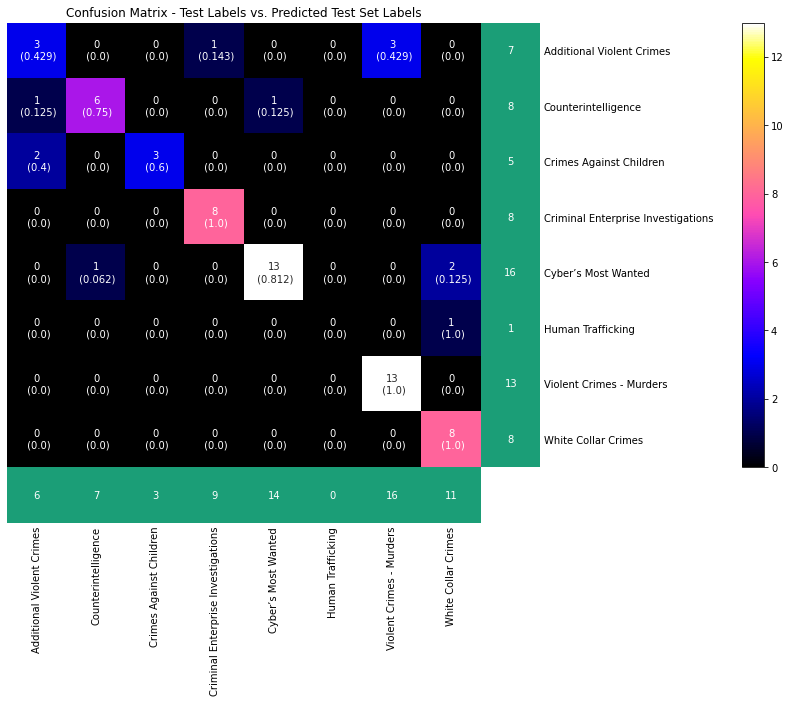

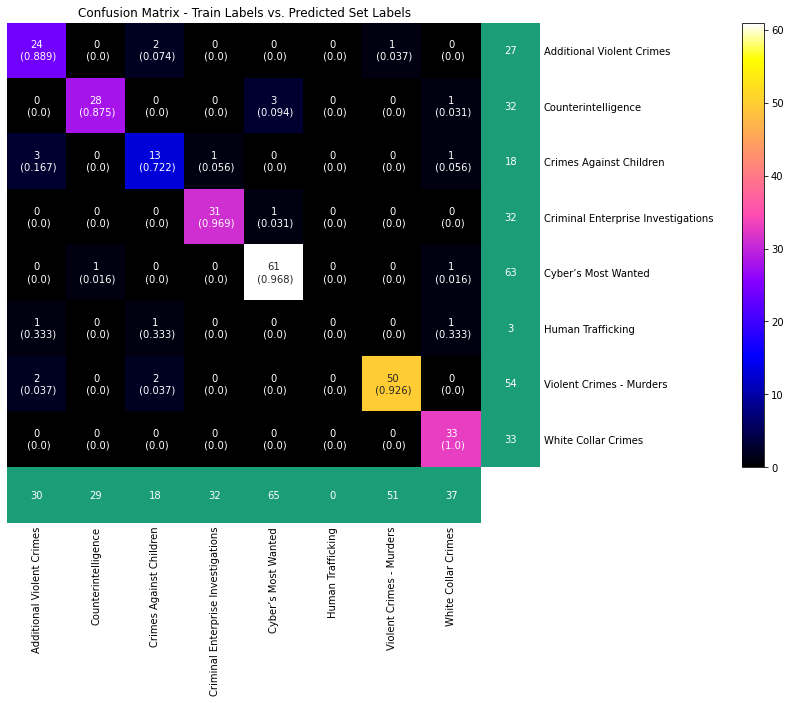

In [94]:
# Plot the confusion matrix to compare classification performance between
# labelling predictions made by model and actual labelling, for both the train
# and test sets

# Confusion Matrix - test data predictions
confusion_matrix_plot_seaborn(cm_test, title = 'Confusion Matrix - Test Labels vs. Predicted Test Set Labels', scaling_factor = 2.3, cmap = 'gnuplot2')

# Confusion Matrix - train data predictions
confusion_matrix_plot_seaborn(cm_train, title = 'Confusion Matrix - Train Labels vs. Predicted Set Labels', scaling_factor = 2.3, cmap = 'gnuplot2')
